In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
from statistics import median
from statistics import mean
import cv2

In [31]:
#row, col = img.shape
def df(img):  # to make a histogram (count distribution frequency)
    values = [0]*256
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            values[img[i,j]]+=1
    return values


def cdf(hist):  # cumulative distribution frequency
    cdf = [0] * len(hist)   #len(hist) is 256
    cdf[0] = hist[0]
    for i in range(1, len(hist)):
        cdf[i]= cdf[i-1]+hist[i]
    # Now we normalize the histogram
    cdf = [ele*255/cdf[-1] for ele in cdf]  
    return cdf

def equalize_image(image):
    img = image
    my_cdf = cdf(df(img))
    # use linear interpolation of cdf to find new pixel values
    import numpy as np
    image_equalized = np.interp(image, range(0,256), my_cdf)
    return image_equalized

#eq = equalize_image(img)

In [15]:
def sec_der_filter(pixelcoor, image2):
    size = [-1,0,1]
    a, b = pixelcoor
    z, w = image2.shape
    out_pixel = 0
    for col in size:
        for row in size:
            if 0 <= a + row < z and 0 <= b + col < w:
                if col or row != 0:
                    out_pixel -= image2[a + row,b + col]
                else:
                    out_pixel += 8 * image2[a + row,b + col]
    return out_pixel
def lap_filter_rgb(image):
    img_rgb = []
    filtereds = []
    for i in range(3):
        img_rgb.append(image[:,:,i])
    filtered_image = np.zeros(list(img_rgb[0].shape))
    x,y = img_rgb[0].shape
    for k in range(3):
        for i in range(x):
            for j in range(y):
                filtered_image[i,j] = sec_der_filter([i,j], img_rgb[k])
        filtereds.append(np.array(filtered_image))
    fil_rgb = np.dstack((filtereds[0],filtereds[1],filtereds[2]))
    fil_rgb = np.array(fil_rgb,dtype = int)
    return(fil_rgb)

In [16]:
def fir_der_filter(pixelcoor, image2):
    size = [-1,0,1]
    a, b = pixelcoor
    z, w = image2.shape
    out_pixel1 = 0
    out_pixel2 = 0
    for col in size:
        for row in size:
            if 0 <= a + row < z and 0 <= b + col < w:
                if row != 0 and col != 0:
                    out_pixel1 += row*(image2[a + row,b + col])
                elif row != 0 and col == 0:
                    out_pixel1 += row*2*(image2[a + row,b + col])
    for col in size:
        for row in size:
            if 0 <= a + row < z and 0 <= b + col < w:
                if col != 0 and row != 0:
                    out_pixel2 += row*(image2[a + row,b + col])
                elif col != 0 and row == 0:
                    out_pixel2 += col*2*(image2[a + row,b + col])    
                    
    out_pixel = abs(out_pixel1) + abs(out_pixel2)
    
    return out_pixel
def grad_filter_rgb(image):
    img_rgb = []
    filtereds = []
    for i in range(3):
        img_rgb.append(image[:,:,i])
    filtered_image = np.zeros(list(img_rgb[0].shape))
    x,y = img_rgb[0].shape
    for k in range(3):
        for i in range(x):
            for j in range(y):
                filtered_image[i,j] = fir_der_filter([i,j], img_rgb[k])
        filtereds.append(np.array(filtered_image))
    fil_rgb = np.dstack((filtereds[0],filtereds[1],filtereds[2]))
    fil_rgb = np.array(fil_rgb,dtype = int)
    return(fil_rgb)

In [5]:
def pix_med_filter(pixelcoor, image2, filtershape):
    size = list(range(-filtershape//2+1,filtershape//2+1))
    a, b = pixelcoor
    z, w = image2.shape
    neigh_pixs = []
    for col in size:
        for row in size:
            if 0 <= a + row < z and 0 <= b + col < w:
                neigh_pixs.append(image2[a+row,b+col])
    out_pixel = median(neigh_pixs)
    return out_pixel
def median_filter(image,filter_size):
    filtered_image = np.zeros(list(image.shape))
    x,y = image.shape
#     count = 0
    for i in range(x):
        for j in range(y):
            filtered_image[i,j] = pix_med_filter([i,j], image, filter_size)
    fil_size = filter_size
    return(filtered_image, fil_size)

In [6]:
def pix_max_filter(pixelcoor, image2, filtershape):
    size = list(range(-filtershape//2+1,filtershape//2+1))
    a, b = pixelcoor
    z, w = image2.shape
    neigh_pixs = []
    for col in size:
        for row in size:
            if 0 <= a + row < z and 0 <= b + col < w:
                neigh_pixs.append(image2[a+row,b+col])
    out_pixel = max(neigh_pixs)
    return out_pixel
def max_filter(image,filter_size):
    filtered_image = np.zeros(list(image.shape))
    x,y = image.shape
#     count = 0
    for i in range(x):
        for j in range(y):
            filtered_image[i,j] = pix_med_filter([i,j], image, filter_size)
    fil_size = filter_size
    return(filtered_image, fil_size)

In [7]:
def pix_max_filter(pixelcoor, image2, filtershape):
    size = list(range(-filtershape//2+1,filtershape//2+1))
    a, b = pixelcoor
    z, w = image2.shape
    neigh_pixs = []
    for col in size:
        for row in size:
            if 0 <= a + row < z and 0 <= b + col < w:
                neigh_pixs.append(image2[a+row,b+col])
    out_pixel = mix(neigh_pixs)
    return out_pixel
def min_filter(image,filter_size):
    filtered_image = np.zeros(list(image.shape))
    x,y = image.shape
#     count = 0
    for i in range(x):
        for j in range(y):
            filtered_image[i,j] = pix_med_filter([i,j], image, filter_size)
    fil_size = filter_size
    return(filtered_image, fil_size)

In [8]:
def rgb_pix_min_filter(pixelcoor, image2, filtershape):
    size = list(range(-filtershape//2+1,filtershape//2+1))
    a, b = pixelcoor
    z, w = image2.shape
    neigh_pixs = []
    for col in size:
        for row in size:
            if 0 <= a + row < z and 0 <= b + col < w:
                neigh_pixs.append(image2[a+row,b+col])
    out_pixel = min(neigh_pixs)
    return out_pixel
def min_filter_rgb(image,filtersize):
    img_rgb = []
    filtereds = []
    for i in range(3):
        img_rgb.append(image[:,:,i])
    filtered_image = np.zeros(list(img_rgb[0].shape))
    x,y = img_rgb[0].shape
    for k in range(3):
        for i in range(x):
            for j in range(y):
                filtered_image[i,j] = rgb_pix_med_filter([i,j], img_rgb[k],filtersize)
        filtereds.append(np.array(filtered_image))
    fil_rgb = np.dstack((filtereds[0],filtereds[1],filtereds[2]))
    fil_rgb = np.array(fil_rgb,dtype = int)
    return fil_rgb,filtersize

In [9]:
def pix_mean_filter(pixelcoor, image2, filtershape):
    size = list(range(-filtershape//2+1,filtershape//2+1))
    a, b = pixelcoor
    z, w = image2.shape
    neigh_pixs = []
    for col in size:
        for row in size:
            if 0 <= a + row < z and 0 <= b + col < w:
                neigh_pixs.append(image2[a+row,b+col])
    out_pixel = mean(neigh_pixs)
    return out_pixel
def mean_filter(image,filter_size):
    filtered_image = np.zeros(list(image.shape))
    x,y = image.shape
#     count = 0
    for i in range(x):
        for j in range(y):
            filtered_image[i,j] = pix_med_filter([i,j], image, filter_size)
    fil_size = filter_size
    return(filtered_image, fil_size)

# First Image:

In [147]:
loc1 = 'C:/Users/sherw/OneDrive/Desktop/DIP_HW2/inputs/P3/IV/ghost_1.jpg'
im1 = Image.open(loc1)
img1 = np.array(im1)

In [149]:
root_img1 = img1**(1/4)
med_img1 = median_filter(root_img1,7)[0]

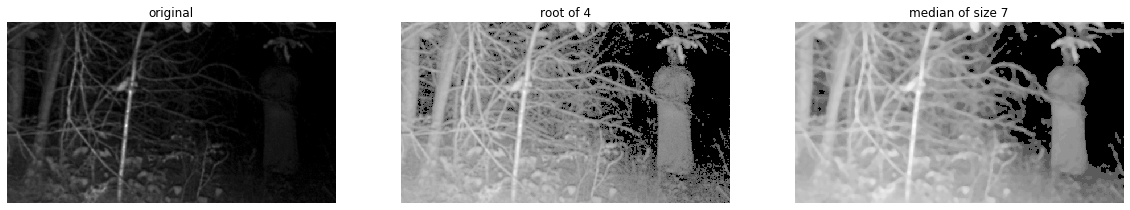

In [150]:
matplotlib.rcParams['figure.figsize'] = [20,20]
plt.subplot(1,3,1)
plt.imshow(img1,'gray')
plt.title('original')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(root_img1,'gray')
plt.title('root of 4')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(med_img1,'gray')
plt.title('median of size 7')
plt.axis('off')
plt.show()

# Second Image: 

In [221]:
loc2 = 'C:/Users/sherw/OneDrive/Desktop/DIP_HW2/inputs/P3/IV/ghost_2.jpg'
im2 = Image.open(loc2)
img2 = np.array(im2)

In [229]:
med_img2,s = median_filter(img2,3)

In [263]:
power_img2 = med_img2 **1.99

In [264]:
#power_img2 = ((power_img2-np.min(power_img2))/(np.max(power_img2)))*256

(-0.5, 499.5, 663.5, -0.5)

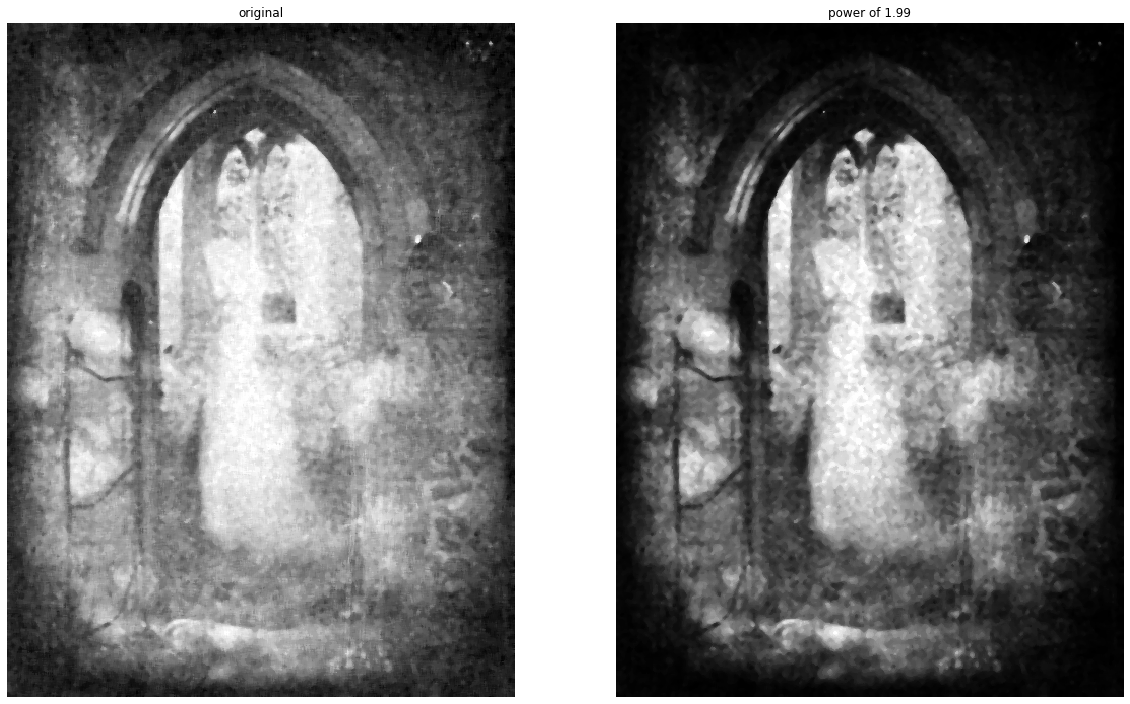

In [265]:
matplotlib.rcParams['figure.figsize'] = [20,20]
plt.subplot(1,2,1)
plt.imshow(img2,'gray')
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(power_img2,'gray')
plt.title('power of 1.99')
plt.axis('off')
plt.show()

# Third Image: 

In [284]:
loc3 = 'C:/Users/sherw/OneDrive/Desktop/DIP_HW2/inputs/P3/IV/ghost_3.jpg'
im3 = Image.open(loc3)
img3 = np.array(im3)

In [317]:
eq_img3 = equalize_image(img3)
root_img3 = eq_img3**(1/2)

In [320]:
root_img3 = ((root_img3-np.min(root_img3))/(np.max(root_img3)))*256

(-0.5, 1180.5, 885.5, -0.5)

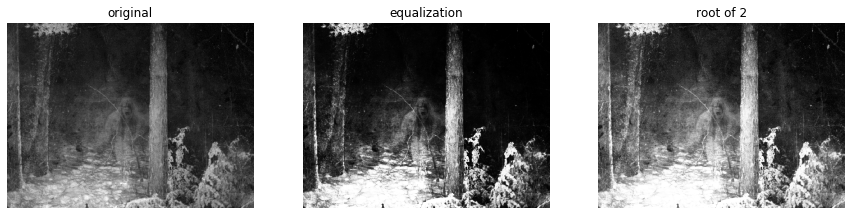

In [324]:
matplotlib.rcParams['figure.figsize'] = [15,15]
plt.subplot(1,3,1)
plt.imshow(img3,'gray')
plt.title('original')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(eq_img3,'gray')
plt.title('equalization')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(root_img3,'gray')
plt.title('root of 2')
plt.axis('off')
plt.show()

# Fourth Image: 

In [19]:
loc4 = 'C:/Users/sherw/OneDrive/Desktop/DIP_HW2/inputs/P3/IV/ghost_4.jpg'
im4 = Image.open(loc4)
img4 = np.array(im4)

In [33]:
median_img4 = median_filter(img4,9)[0]
median_img4 = np.array(median_img4,dtype=int)

KeyboardInterrupt: 

In [35]:
eq_img4 = equalize_image(median_img4)
power_img4 = eq_img4**(1.7)
#median_img4 = median_filter(power_img4,7)[0]

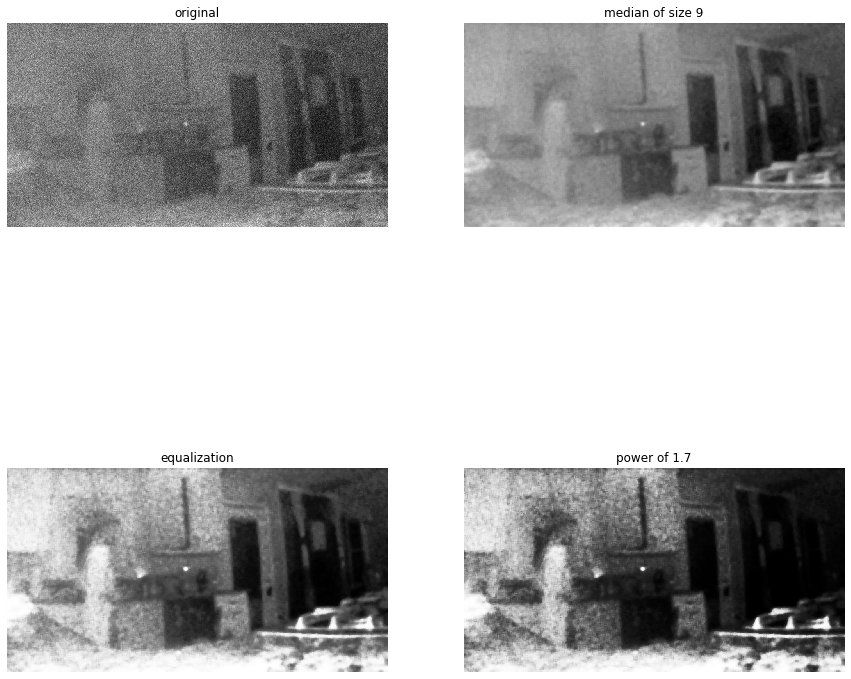

In [34]:
matplotlib.rcParams['figure.figsize'] = [15,15]
plt.subplot(2,2,1)
plt.imshow(img4,'gray')
plt.title('original')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(median_img4,'gray')
plt.title('median of size 9')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(eq_img4,'gray')
plt.title('equalization')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(power_img4,'gray')
plt.title('power of 1.7')
plt.axis('off')
plt.show()